In [1]:
import torch
import math
from torch import Tensor
import matplotlib.pyplot as plt 

In [2]:
def generate_disc_set(nb):
    input_ = Tensor(nb, 2).uniform_(0,1)
    disk_center = Tensor(nb, 2).fill_(0.5)
    #ones_ = torch.ones(nb,2)
    R = 1/math.sqrt(2*math.pi) # Radius of the disk
    target = (R - (disk_center - input_).pow(2).sum(1).sqrt()).sign()#.long()
    target.add_(1).div_(2) # to transform [-1,1] into [0,1]
    return input_, target

train_input, train_target = generate_disc_set(1000)
test_input, test_target = generate_disc_set(1000)

mini_batch_size = 100
print (train_input.size(), train_target.size())
print(train_target.size())

torch.Size([1000, 2]) torch.Size([1000])
torch.Size([1000])


#samples:        torch.Size([1000, 2])
#true_samples:   torch.Size([482, 2])
#false_samples:  torch.Size([518, 2])
torch.Size([1000, 2])


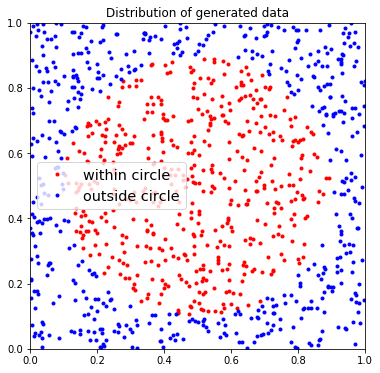

In [3]:
def plot_data(input_, target_, figure_size = 6):
    input_true = torch.Tensor(0,2)
    input_false = torch.Tensor(0,2)
    for i,x in enumerate(input_):
        if target_[i] == 0 :
            input_false = torch.cat((input_false, input_[i,:].view(-1,2)),0 )
        else :
            input_true = torch.cat( (input_true, input_[i,:].view(-1,2)),0 )
    print ('#samples:       ',input_.size())
    print ('#true_samples:  ',input_true.size())
    print ('#false_samples: ',input_false.size())
    p1 = plt.figure(1,figsize=(figure_size,figure_size))
    plt.plot(input_true[:,0].numpy(),input_true[:,1].numpy(),'r.',label='within circle')
    plt.plot(input_false[:,0].numpy(),input_false[:,1].numpy(),'b.',label='outside circle')
    plt.xlim(0,1), plt.ylim(0,1)
    plt.legend(fontsize='x-large')
    plt.title('Distribution of generated data')
    
    
plot_data(train_input, train_target)
train_target = torch.cat((1-train_target.unsqueeze(1), train_target.unsqueeze(1)),1)
print(train_target.size())

In [4]:
mu, std = train_input.mean(),train_input.std()
train_input.sub_(mu).div_(std)
mu, std = test_input.mean(),test_input.std()
test_input.sub_(mu).div_(std)        


 0.4245 -1.1917
 0.2543  0.7456
 0.2015  0.7130
       ⋮        
-0.0793  0.5769
 0.6257  1.1558
-1.6459 -1.4804
[torch.FloatTensor of size 1000x2]

In [5]:
class Module ( object ) :
    def forward ( self , * input ) :
        raise NotImplementedError
        
    def backward ( self , * gradwrtoutput ) :
        raise NotImplementedError
        
    def param ( self ) :
        return [] 
    
    def zero_grad ( self ) :
        pass
    
    def reset_params( self ) :
        pass
    
class SGDOptimizer():
    def __init__(self, Sequential, lr):
        super().__init__()
        
        self.Sequential = Sequential
        self.lr = lr
        
    def step(self):
        for param in self.Sequential.params:
            param[0][0].add_(- self.lr * param[1][0])
            param[0][1].add_(- self.lr * param[1][1])
        
        self.Sequential.zero_grad()

In [6]:
class Linear(Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        
        self.weights = torch.Tensor(out_features, in_features).normal_(mean=0, std = 1)
        self.bias = torch.Tensor(out_features).uniform_(0,0)
        
        self.dl_dw = torch.Tensor(out_features, in_features)
        self.dl_db = torch.Tensor(out_features)
        self.zero_grad()
        
        self.params = [(self.weights, self.bias),(self.dl_dw, self.dl_db)]
        
    def forward(self,x):
        self.x = x
        if(x.size()[1]!=self.in_features):
            raise TypeError('Size of x should correspond to size of linear module')
        return torch.mm(x,self.weights.t()) + self.bias.expand(x.size()[0], self.out_features)
    
    def backward(self, d_dx):
        self.dl_db = torch.mean(d_dx,0)
        self.dl_dw = torch.mm(d_dx.t(), self.x)
        return torch.mm(d_dx,self.weights)
        
    def param(self):
        self.params = [(self.weights, self.bias),(self.dl_dw, self.dl_db)]
        return self.params
    
    def zero_grad(self):
        self.dl_db.zero_()
        self.dl_dw.zero_()
        
    def reset_params(self):
        self.weights.normal_(mean=0, std = 1)
        self.bias.uniform_(0,0)
        self.zero_grad()
        self.params = [(self.weights, self.bias),(self.dl_dw, self.dl_db)]
               
        
class Sequential(Module):
    def __init__(self, modules, loss):
        super().__init__()
        
        self.modules = modules
        self.loss = loss
        self.params = []
        self.param()
        
    def add(self, new_modules):
        self.modules.append(new_modules)

    def forward(self, x):
        for module in self.modules:
            x = module.forward(x)
        return x

    def backward(self):
        d_dx = self.loss.backward()  
        for module in reversed(self.modules):
            d_dx = module.backward(d_dx)
        self.param()

    def zero_grad(self):
        for module in self.modules:
            module.zero_grad()

    def param(self):
        self.params = []
        for module in self.modules:
            if(module.params):
                self.params.append(module.param())
                
    def reset_params(self):
        for module in self.modules:
            module.reset_params()
                
            
class LeakyReLU(Module):
    def __init__(self, alpha):
        super().__init__()
        
        self.params = []
        self.alpha = alpha
        
    def forward(self, x):
        self.x = x
        return x*((x>0).type(torch.FloatTensor)+self.alpha*(x<0).type(torch.FloatTensor))
    
    def backward(self, d_dx):
        return d_dx*((self.x>0).type(torch.FloatTensor)+self.alpha*(self.x<0).type(torch.FloatTensor))
        
    def param(self):
        return self.params
    
class ReLU(Module):
    def __init__(self):
        super().__init__()
        
        self.params = []
        
    def forward(self, x):
        self.x = x
        return x*(x>0).type(torch.FloatTensor)
    
    def backward(self, d_dx):
        return d_dx*(self.x>0).type(torch.FloatTensor)
        
    def param(self):
        return self.params
    
    
class Tanh(Module):
    def __init__(self):
        super().__init__()
        
        self.params = []
        
    def forward(self, x):
        self.x = x
        return 0.5*(1+x.tanh())
    
    def backward(self, d_dx):
        return 0.5*d_dx*(1-torch.tanh(self.x)**2)
    
    def param(self):
        return self.params
    
class Sigmoid(Module):
    def __init__(self):
        super().__init__()
        
        self.params = []
        
    def forward(self, x):
        self.x = x
        return torch.sigmoid(x)
    
    def backward(self, d_dx):
        return d_dx * (torch.sigmoid(self.x*(1-torch.sigmoid(self.x))))
    
    def param(self):
        return self.params
    
    
class LossMSE(Module):
    def __init__(self):
        super().__init__()
        
        self.params = []
        
    def forward(self, y, t):
        self.y = y
        self.t = t
        return torch.dist(y,t,p=2)
    
    def backward(self):
        return 2*(self.y-self.t)
    
    def param(self):
        return self.params
    


In [7]:
Lin1 = Linear(2,20)
Lin2 = Linear(20,20)
Lin3 = Linear(20,2)
act1 = ReLU()
act2 = ReLU()
act3 = Tanh()
layers = [
    Lin1,
    act1,
    #Lin2,
    #act2,
    Lin3,
    act3]
loss = LossMSE()
model = Sequential(layers, loss)
optim = SGDOptimizer(model, 0.01)


In [8]:
loss_list = []
train_acc = []

for epoch in range(200):
    
    print("\n Epoch", epoch)
    
    batch_size = 50
    train_loss = 0
    train_accuracy = 0
    
    model.zero_grad()
    
    for b in range(0, train_input.size()[0], batch_size):
        output = model.forward(train_input[b:b+batch_size,:])
        batch_loss = loss.forward(output, train_target[b:b+batch_size,:])
        train_loss += batch_loss
        model.backward()
        optim.step()
        
        _, pred = torch.max(output,1)
        _, target = torch.max(train_target[b:b+batch_size],1)
        
        train_accuracy += torch.sum(pred==target)
        
    print("\nTraining accuracy : ", train_accuracy/train_target.size()[0])      
    print("\nTraining loss : ", train_loss)
    loss_list.append(train_loss)
    train_acc.append(train_accuracy)



 Epoch 0

Training accuracy :  0.528

Training loss :  129.4756269454956

 Epoch 1

Training accuracy :  0.528

Training loss :  119.62719392776489

 Epoch 2

Training accuracy :  0.534

Training loss :  114.03984355926514

 Epoch 3

Training accuracy :  0.543

Training loss :  108.92687034606934

 Epoch 4

Training accuracy :  0.559

Training loss :  105.16248893737793

 Epoch 5

Training accuracy :  0.637

Training loss :  93.88619804382324

 Epoch 6

Training accuracy :  0.685

Training loss :  88.8040680885315

 Epoch 7

Training accuracy :  0.713

Training loss :  86.45806860923767

 Epoch 8

Training accuracy :  0.735

Training loss :  84.27055287361145

 Epoch 9

Training accuracy :  0.76

Training loss :  82.24723601341248

 Epoch 10

Training accuracy :  0.772

Training loss :  80.43394899368286

 Epoch 11

Training accuracy :  0.772

Training loss :  79.51917099952698

 Epoch 12

Training accuracy :  0.789

Training loss :  77.82689809799194

 Epoch 13

Training accuracy :  


Training accuracy :  0.949

Training loss :  38.83255010843277

 Epoch 114

Training accuracy :  0.947

Training loss :  38.84410488605499

 Epoch 115

Training accuracy :  0.948

Training loss :  38.76693195104599

 Epoch 116

Training accuracy :  0.948

Training loss :  38.712146401405334

 Epoch 117

Training accuracy :  0.948

Training loss :  38.56728821992874

 Epoch 118

Training accuracy :  0.948

Training loss :  38.55580049753189

 Epoch 119

Training accuracy :  0.948

Training loss :  38.50082188844681

 Epoch 120

Training accuracy :  0.948

Training loss :  38.41040927171707

 Epoch 121

Training accuracy :  0.949

Training loss :  38.44199454784393

 Epoch 122

Training accuracy :  0.949

Training loss :  38.33672070503235

 Epoch 123

Training accuracy :  0.949

Training loss :  38.24054557085037

 Epoch 124

Training accuracy :  0.948

Training loss :  38.23663794994354

 Epoch 125

Training accuracy :  0.947

Training loss :  38.17097955942154

 Epoch 126

Training a

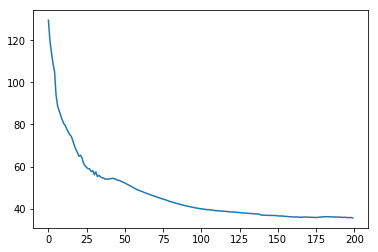

In [13]:
plt.plot(loss_list)

In [11]:
test_output = model.forward(test_input)
_, pred = torch.max(test_output,1)

torch.sum(pred == test_target.type(torch.LongTensor))

968

In [ ]:
output = model.forward(train_input)
print(output)
train_loss = loss.forward(output,train_target)
print(train_loss)


In [ ]:
x = train_input
x = Lin1.forward(x)
x = act1.forward(x)
#x = Lin2.forward(x)
#x = act2.forward(x)
x = Lin3.forward(x)
x = act3.forward(x)
print(x)

In [ ]:
dx = loss.backward()
dx = act3.backward(dx)
dx = Lin3.backward(dx)
#dx = act2.backward(dx)
#dx = Lin2.backward(dx)
#dx = act1.backward(dx)
#dx = Lin1.backward(dx)
print(dx)

optim.step()

In [ ]:
model.reset_params()

In [ ]:
Lin3.dl_dw